In [5]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sys
import os
plt.rcParams.update({'savefig.dpi':100})
plt.rcParams.update({'font.size': 16})

In [3]:
# break_points=[0]+list(np.load('NoAuction_n_ticks.npy').T.flatten().cumsum())
# data=np.load('NoAuction_DecPre.npy')
# y=np.array([data[break_points[i]+100:break_points[i+1]-5,43] for i in range(len(break_points)-1)]).reshape(5,10)
# y=[np.concatenate(y[i]) for i in range(5)]

# sample_idx=np.zeros([3,5]).astype(int)
# for i in range(5):
#     sample_idx[:,i]=[np.random.choice(np.where(y[i]==j+1)[0], size=1) for j in range(3)]
# sample_idx+=np.concatenate(([0], np.cumsum([len(y[i]) for i in range(5)])))[:-1]
# print(sample_idx)

sample_idx=np.array([[  3111,  75051, 128117, 193124, 348771],
                     [ 10613,  87037, 127527, 237710, 278609],
                     [   568,  72169, 118492, 181463, 243289]])

none (389087, 100, 40)


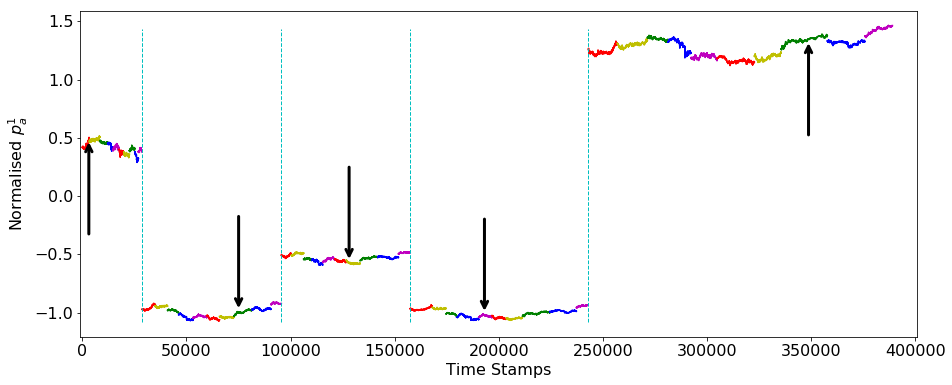

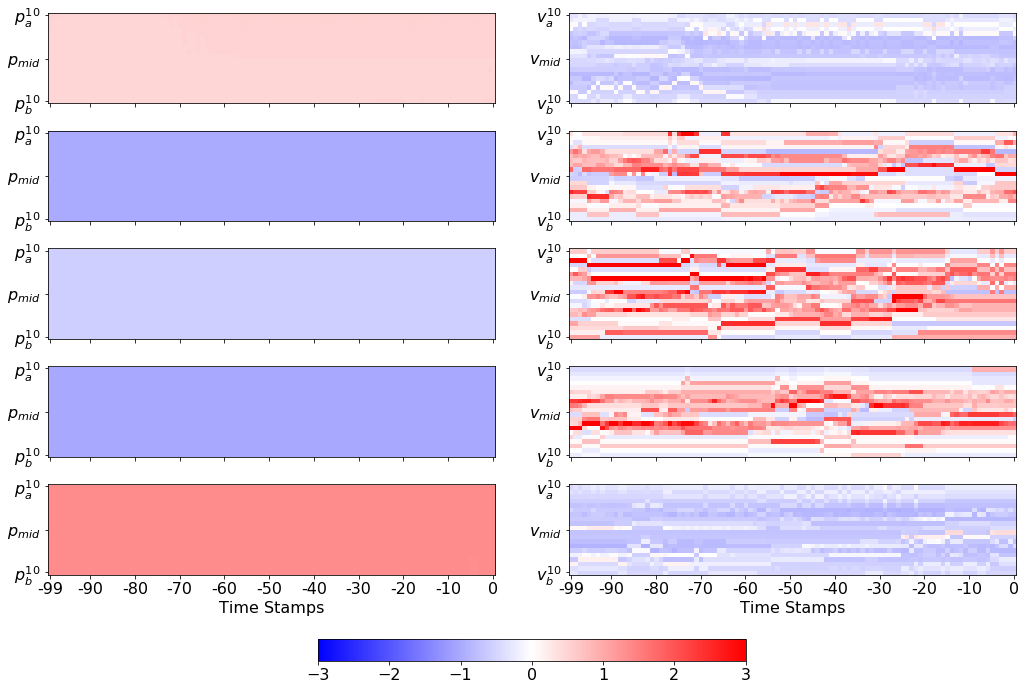

stock (389087, 100, 40)


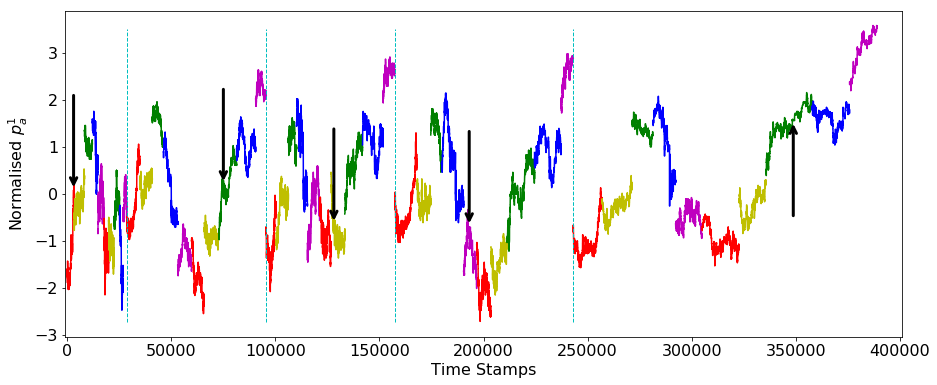

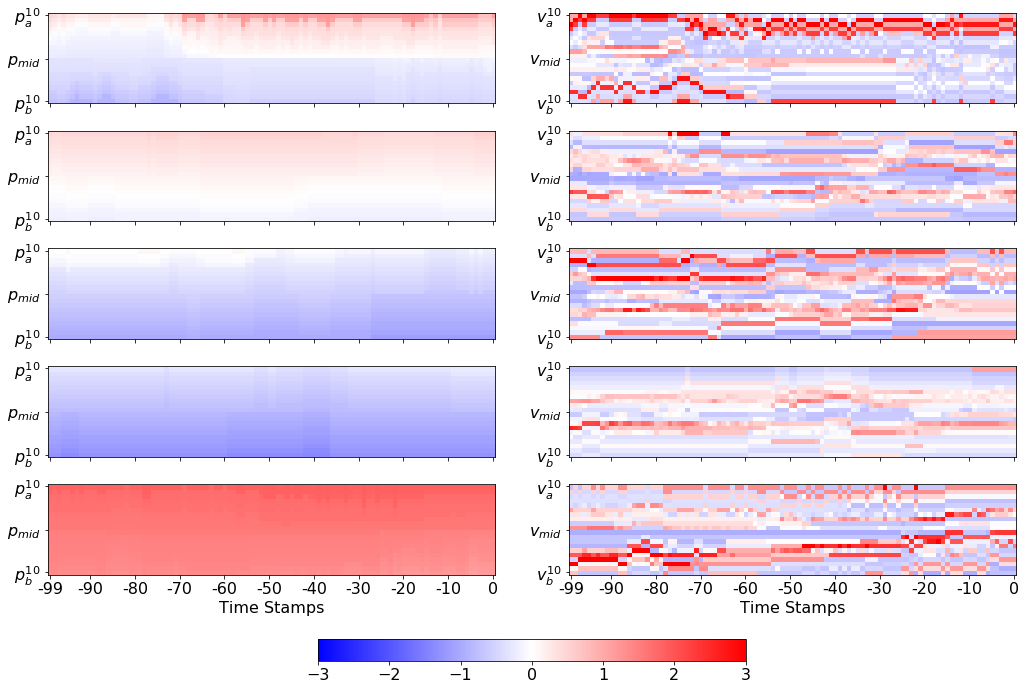

stock-stationary (389087, 100, 40)


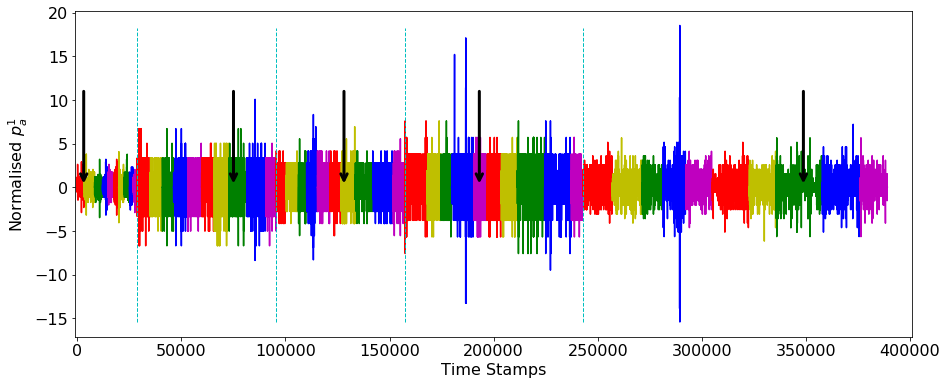

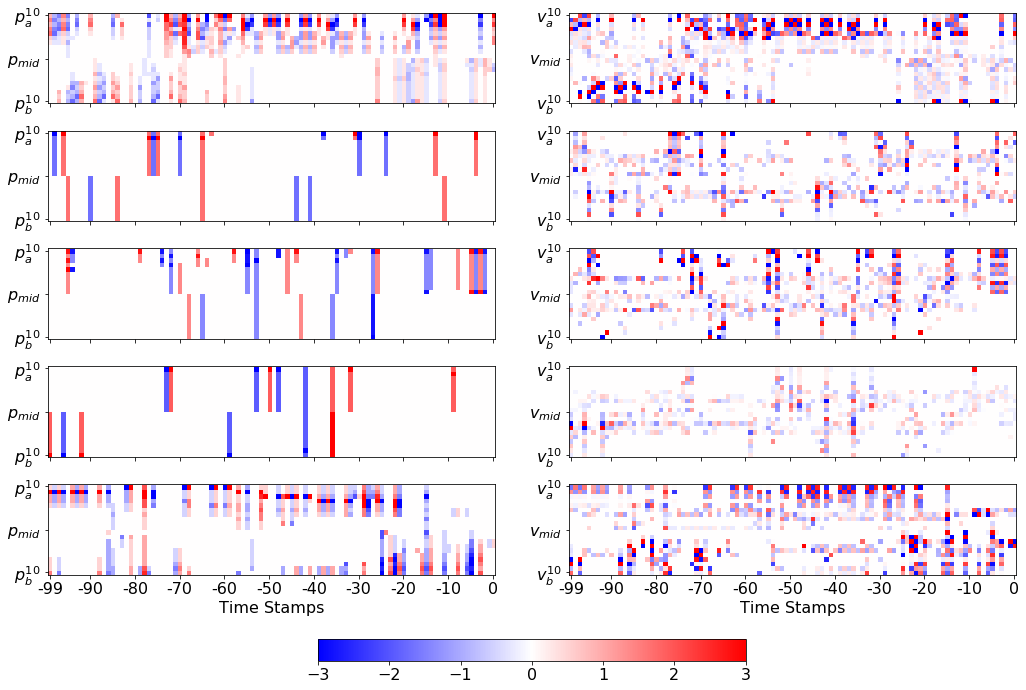

In [6]:
colors=['r','y','g','b','m']
for normalization_type in ['none','stock','stock-stationary']:
    n_ticks=np.load('NoAuction_n_ticks.npy').T
    dataset_name='Zscore' if normalization_type=='none' else 'DecPre'
    data=np.load('NoAuction_'+dataset_name+'.npy')
    y_type='y1true'
    y_type_dict={'y1':40,'y2':41,'y5':42,'y1true':43,'y2true':44,'y5true':45}
    x=[]
    y=[]
    input_length=100
    
    # split data by stock and day
    break_points=[0]+list(n_ticks.flatten().cumsum())
    data = [data[break_points[i]:break_points[i+1]] for i in range(len(break_points)-1)]
    data = np.array(data).reshape(5,10)
           
    if 'stationary' in normalization_type:
        for stock in range(5):
            for day in range(10):
                data[stock][day][:,:40]=data[stock][day][:,:40]-np.roll(data[stock][day][:,:40],1,axis=0)

    normalization_factors=np.tile(np.stack((np.zeros([5, 10]),np.ones([5, 10])), axis=0), (2,1,1))
    if 'stock' in normalization_type and not 'day' in normalization_type:    
        for stock in range(5):
            training_data=np.vstack(data[stock][:5])
            for i in range(2):
                normalization_factors[i*2+0, stock]=np.mean(training_data[:,range(i,40,2)])
                normalization_factors[i*2+1, stock]=np.std (training_data[:,range(i,40,2)])
    elif 'day' in normalization_type:
        for stock in range(5):
            for day in range(10):
                training_data=data[stock][max(day-1,0)]
                for i in range(2):
                    normalization_factors[i*2+0, stock, day]=np.mean(training_data[:,range(i,40,2)])
                    normalization_factors[i*2+1, stock, day]=np.std (training_data[:,range(i,40,2)]) 

    for stock in range(5):
        for day in range(10):
            for field in range(2):
                data[stock][day][:, range(field,40,2)]-=normalization_factors[field*2+0, stock, day]
                data[stock][day][:, range(field,40,2)]/=normalization_factors[field*2+1, stock, day]
            valid_ticks=np.arange(input_length, len(data[stock][day])-5)+1
            x.append(data[stock][day][np.array([list(range(i-input_length,i)) for i in valid_ticks]), :40])
            y.append(np.eye(3)[data[stock][day][valid_ticks-1,y_type_dict[y_type]].astype(int)-1])
    x=np.concatenate(x)
    y=np.concatenate(y)
    print(normalization_type, x.shape)
    break_points=np.concatenate(([0], np.cumsum(n_ticks.flatten()-105)))
    
    if normalization_type=='none':
        normalization_type='default z-score'
    f=plt.figure(figsize=(15,6))
    _=plt.xlabel('Time Stamps')
    _=plt.ylabel('Normalised $p_a^1$')
    _=plt.xlim([-1000,401000])
    for i in range(len(break_points)-1):
        _=plt.plot(range(break_points[i],break_points[i+1]),x[break_points[i]:break_points[i+1]][:,-1,0],
                   color=colors[i%5])
    
    y_lim=np.array(plt.gca().get_ylim())
    for stock in range(1,5):
        _=plt.plot(np.array(break_points[10*stock]).repeat(2), y_lim*0.9, 'c--', linewidth=1)
    y_range=y_lim[1]-y_lim[0]
    
    for i in range(5):
        direction = np.sign(y_lim.mean()-x[sample_idx[0,i],-1,0])
        _=plt.annotate('', xy=(sample_idx[0,i],x[sample_idx[0,i],-1,0]+0.005*direction*y_range), 
                         xytext=(sample_idx[0,i],x[sample_idx[0,i],-1,0]+0.3*direction*y_range), 
                         arrowprops=dict(arrowstyle="->",color='black', linewidth=3))
    _=plt.show()
    f.savefig(normalization_type+'.jpg')   
    
    f,axes=plt.subplots(5,2,figsize=(16,10), sharex=True, sharey='col')
#     f.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, wspace=0.08, hspace=0.12)
    f.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, wspace=0.01, hspace=0.3)
    idx = np.concatenate([np.concatenate((np.flip(np.arange(i+2,40,4)), np.arange(i,40,4))) for i in range(2)])
    sample_x=x[sample_idx[0]][:,:,idx].reshape(-1,input_length,2,20)

    for i in range(2):
        for sample in range(5):
            plt.sca(axes[sample,i])
            im=plt.imshow(sample_x[sample,:,i,:].T, vmin=-3.0, vmax=3.0, cmap='bwr', origin='lower')
            _=plt.xticks(np.append([0],np.arange(9,100,10)),np.append(['-99'],np.arange(-90,1,10).astype(str)))
            _=plt.ylim([-0.5, 19.75])
            if i==0:
                _=plt.yticks([0,9.5,19.25],['$p_b^{10}$', '$p_{mid}$', '$p_a^{10}$'])
            else:
                _=plt.yticks([0,9.5,19.25],['$v_b^{10}$', '$v_{mid}$', '$v_a^{10}$'])
            if sample==4:
                _=plt.xlabel('Time Stamps')
    _=f.colorbar(im, ax=axes,location='bottom',fraction=0.033, pad=0.10)

    f.savefig(normalization_type+'_sample.jpg')
    _=plt.show()
    

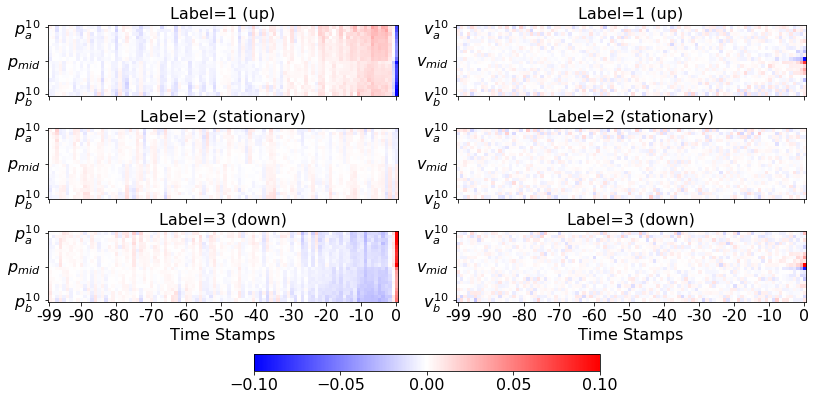

In [16]:
x=x[:,:,idx].reshape(-1,input_length,2,20)
mean_x=np.zeros([3,input_length,2,20])
for label in range(1,4):
    a = x[np.argmax(y,axis=1)==label-1]
    mean_x[label-1]=a[np.random.choice(range(len(a)),size=40000,replace=False)].mean(axis=0)

f,axes=plt.subplots(3,2,figsize=(16,6), sharex=True, sharey=False)
f.subplots_adjust(left=0.05, bottom=0.1, right=0.95, top=0.9, wspace=-0.35, hspace=0.45)
for i in range(2):
    for label in range(1,4):
        plt.sca(axes[label-1,i])
        im=plt.imshow(mean_x[label-1,:,i].T, vmin=-0.1, vmax=0.1, cmap='bwr', origin='lower')
        
        _=axes[label-1,i].set_xticks(np.append([0],np.arange(9,100,10)))
        _=axes[label-1,i].set_xticklabels(np.append(['-99'],np.arange(-90,1,10).astype(str)))
        _=axes[label-1,i].set_yticks([0,9.5,19])
        _=plt.xticks(np.append([0],np.arange(9,100,10)),np.append(['-99'],np.arange(-90,1,10).astype(str)))
        _=plt.ylim([-0.5, 19.75])
        if i==0:
            _=plt.yticks([0,9.5,19.25],['$p_b^{10}$', '$p_{mid}$', '$p_a^{10}$'])
        else:
            _=plt.yticks([0,9.5,19.25],['$v_b^{10}$', '$v_{mid}$', '$v_a^{10}$'])
        if label==3:
            _=plt.xlabel('Time Stamps')
_=f.colorbar(im, ax=axes,location='bottom',fraction=0.05, pad=0.15, ticks=np.arange(-0.1,0.11,0.05))

_=axes[0,0].set_title('Label=1 (up)', fontsize=16)
_=axes[0,1].set_title('Label=1 (up)', fontsize=16)
_=axes[1,0].set_title('Label=2 (stationary)', fontsize=16)
_=axes[1,1].set_title('Label=2 (stationary)', fontsize=16)
_=axes[2,0].set_title('Label=3 (down)', fontsize=16)
_=axes[2,1].set_title('Label=3 (down)', fontsize=16)
f.savefig('class_average.jpg')
_=plt.show()
